In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Rules
- Space for P (progenitor) cells is a continuous 1d line (P-space) representing the basal layer.
- Space for D (differentiating) cells is a continuous 1d line (D-space) representing suprabasal layers.
- P- and D-cell coordinates can be anywhere in [0, 1.].
- P-cells divide at a rate *lambda* or a division waiting time of *1/lambda*.
- D-cells migrate from the basal layer to suprabasal layers at a rate *gamma* in a process called stratification. 
- D-cells are shed at a rate *sigma* or a shedding waiting time of *1/sigma*.
- The mean lifetime of D-cells is tau = 1/gamma + 1/sigma. Thus the loss rate of D-cells is tau_r = (1/gamma + 1/sigma)^-1

# Initialization
1. Given a P-cell population size Np, place P cells randomly on the line by drawing from a uniform distribution. All P-cells are genotypically and phenotypically the same at this time.
2. A waiting time for next division of every P-cell is assigned by drawing from an exponential distribution. Place waiting times into the division queue.
3. For each division event, determine if P-cell will divide into P+P cells, P+D cells, or D+D cells.
- Pr[event = P+P] = r; Place the parent and daughter in P-space midpoint between neighborssuch that neighbor-P-P-neighbor are equidistant.
- Pr[event = P+D] = 1 - 2r; The parent remains in the same position in P-space and the daughter is placed in D-space based on a unit normal distribution with mean equal to the same position as the parent.
- Pr[event = D+D] = r; The parent is deleted from P-space and two daughters are placed in D-space  based on a normal distribution with mean equal to the same position as the parent and stdev equal to 2. Position of directly adjcent parental neighbors are adjusted to be equidistant to their respective neighbors.
4. For each new D-cell, a waiting time for loss is assigned by drawing from an exponential distribution. Place waiting times into the loss queue.
5. Iterate simulation until the density of D-cells reaches an equilibrium.
6. Save equilibrium states randomly. These states will be the starting point of simulations.



In [2]:
from bisect import bisect_left, bisect_right

class SortedCollection(object):
    '''Sequence sorted by a key function.

    SortedCollection() is much easier to work with than using bisect() directly.
    It supports key functions like those use in sorted(), min(), and max().
    The result of the key function call is saved so that keys can be searched
    efficiently.

    Instead of returning an insertion-point which can be hard to interpret, the
    five find-methods return a specific item in the sequence. They can scan for
    exact matches, the last item less-than-or-equal to a key, or the first item
    greater-than-or-equal to a key.

    Once found, an item's ordinal position can be located with the index() method.
    New items can be added with the insert() and insert_right() methods.
    Old items can be deleted with the remove() method.

    The usual sequence methods are provided to support indexing, slicing,
    length lookup, clearing, copying, forward and reverse iteration, contains
    checking, item counts, item removal, and a nice looking repr.

    Finding and indexing are O(log n) operations while iteration and insertion
    are O(n).  The initial sort is O(n log n).

    The key function is stored in the 'key' attibute for easy introspection or
    so that you can assign a new key function (triggering an automatic re-sort).

    In short, the class was designed to handle all of the common use cases for
    bisect but with a simpler API and support for key functions.

    >>> from pprint import pprint
    >>> from operator import itemgetter

    >>> s = SortedCollection(key=itemgetter(2))
    >>> for record in [
    ...         ('roger', 'young', 30),
    ...         ('angela', 'jones', 28),
    ...         ('bill', 'smith', 22),
    ...         ('david', 'thomas', 32)]:
    ...     s.insert(record)

    >>> pprint(list(s))         # show records sorted by age
    [('bill', 'smith', 22),
     ('angela', 'jones', 28),
     ('roger', 'young', 30),
     ('david', 'thomas', 32)]

    >>> s.find_le(29)           # find oldest person aged 29 or younger
    ('angela', 'jones', 28)
    >>> s.find_lt(28)           # find oldest person under 28
    ('bill', 'smith', 22)
    >>> s.find_gt(28)           # find youngest person over 28
    ('roger', 'young', 30)

    >>> r = s.find_ge(32)       # find youngest person aged 32 or older
    >>> s.index(r)              # get the index of their record
    3
    >>> s[3]                    # fetch the record at that index
    ('david', 'thomas', 32)

    >>> s.key = itemgetter(0)   # now sort by first name
    >>> pprint(list(s))
    [('angela', 'jones', 28),
     ('bill', 'smith', 22),
     ('david', 'thomas', 32),
     ('roger', 'young', 30)]

    '''

    def __init__(self, iterable=(), key=None):
        self._given_key = key
        key = (lambda x: x) if key is None else key
        decorated = sorted((key(item), item) for item in iterable)
        self._keys = [k for k, item in decorated]
        self._items = [item for k, item in decorated]
        self._key = key

    def _getkey(self):
        return self._key

    def _setkey(self, key):
        if key is not self._key:
            self.__init__(self._items, key=key)

    def _delkey(self):
        self._setkey(None)

    key = property(_getkey, _setkey, _delkey, 'key function')

    def clear(self):
        self.__init__([], self._key)

    def copy(self):
        return self.__class__(self, self._key)

    def __len__(self):
        return len(self._items)

    def __getitem__(self, i):
        return self._items[i]

    def __iter__(self):
        return iter(self._items)

    def __reversed__(self):
        return reversed(self._items)

    def __repr__(self):
        return '%s(%r, key=%s)' % (
            self.__class__.__name__,
            self._items,
            getattr(self._given_key, '__name__', repr(self._given_key))
        )

    def __reduce__(self):
        return self.__class__, (self._items, self._given_key)

    def __contains__(self, item):
        k = self._key(item)
        i = bisect_left(self._keys, k)
        j = bisect_right(self._keys, k)
        return item in self._items[i:j]

    def index(self, item):
        'Find the position of an item.  Raise ValueError if not found.'
        k = self._key(item)
        i = bisect_left(self._keys, k)
        j = bisect_right(self._keys, k)
        return self._items[i:j].index(item) + i

    def count(self, item):
        'Return number of occurrences of item'
        k = self._key(item)
        i = bisect_left(self._keys, k)
        j = bisect_right(self._keys, k)
        return self._items[i:j].count(item)

    def insert(self, item):
        'Insert a new item.  If equal keys are found, add to the left'
        k = self._key(item)
        i = bisect_left(self._keys, k)
        self._keys.insert(i, k)
        self._items.insert(i, item)

    def insert_right(self, item):
        'Insert a new item.  If equal keys are found, add to the right'
        k = self._key(item)
        i = bisect_right(self._keys, k)
        self._keys.insert(i, k)
        self._items.insert(i, item)

    def remove(self, item):
        'Remove first occurence of item.  Raise ValueError if not found'
        i = self.index(item)
        del self._keys[i]
        del self._items[i]

    def find(self, k):
        'Return first item with a key == k.  Raise ValueError if not found.'
        i = bisect_left(self._keys, k)
        if i != len(self) and self._keys[i] == k:
            return self._items[i]
        raise ValueError('No item found with key equal to: %r' % (k,))

    def find_le(self, k):
        'Return last item with a key <= k.  Raise ValueError if not found.'
        i = bisect_right(self._keys, k)
        if i:
            return self._items[i-1]
        raise ValueError('No item found with key at or below: %r' % (k,))

    def find_lt(self, k):
        'Return last item with a key < k.  Raise ValueError if not found.'
        i = bisect_left(self._keys, k)
        if i:
            return self._items[i-1]
        raise ValueError('No item found with key below: %r' % (k,))

    def find_ge(self, k):
        'Return first item with a key >= equal to k.  Raise ValueError if not found'
        i = bisect_left(self._keys, k)
        if i != len(self):
            return self._items[i]
        raise ValueError('No item found with key at or above: %r' % (k,))

    def find_gt(self, k):
        'Return first item with a key > k.  Raise ValueError if not found'
        i = bisect_right(self._keys, k)
        if i != len(self):
            return self._items[i]
        raise ValueError('No item found with key above: %r' % (k,))

    def argfind(self, k):
        'ADDED: Return the index of the item with a key == k.  Raise ValueError if not found.'
        try:
            r = self.find(k)
            return self.index(r)
        except Exception as e:
            raise e

In [3]:
from collections import namedtuple

# Implement P-cell as a namedtuple with properties pos (in P-space), 
# wait (division waiting time), lineage
Pcell = namedtuple('Pcell', ['pos', 'wait', 'lineage'])

# Implement D-cell as a namedtiple with properties pos (in D-space),
# wait (loss waiting time), lineage
Dcell = namedtuple('Dcell', ['pos', 'wait', 'lineage'])

# Event queue contains either DivisionEvent or LossEvent
DivisionEvent = namedtuple('DivisionEvent', ['pos', 'wait', 'lineage'])
LossEvent = namedtuple('LossEvent', ['pos', 'wait', 'lineage'])

In [4]:
# P-cell population size
Np = int(1e4)

# Rate of progenitor cell division
division_rate = 5.
division_rate_r = np.reciprocal(division_rate)
# Rate of differentiating cell loss
# Reciprocal loss_rate_r is the mean lifetime of D-cells
loss_rate = 1.
loss_rate_r = np.reciprocal(loss_rate)

# progenitor and differentiation probabilities
pp_prob = 0.1
pd_prob = 0.8
dd_prob = 0.1

# Wild time lineage id
default_lineage_id = 0

# RNG seed
seed = 64745

In [5]:
expected_nbr_distance = 1 / (2*Np)

In [6]:
def division_fate(pp_prob, pd_prob, dd_prob):
    pp_threshold = pp_prob
    pd_threshold = pp_threshold + pd_prob
    i = rng.random()
    if i < pp_threshold:  # p+p
        return 0
    elif i < pd_threshold:  # p+d
        return 1
    return 2

def find_nbrs_pos(space:SortedCollection, pos:float):
    try:
        l_neighbor = space.find_lt(pos)
        l_neighbor_pos = l_neighbor.pos
    except ValueError:
        # Dividing P-cell is the leftmost cell, do periodic boundary adjustment
        # Get rightmost P-cell as neighbor
        l_neighbor = space[-1]
        l_neighbor_pos = l_neighbor.pos - 1.
    # Get right neighbor of dividing P-cell
    try:
        r_neighbor = space.find_gt(pos)
        r_neighbor_pos = r_neighbor.pos
    except ValueError:
        # Dividing P-cell is the rightmost cell, do periodic boundary adjustment
        # Get leftmost P-cell as neighbor
        r_neighbor = space[0]
        r_neighbor_pos = r_neighbor.pos
    return l_neighbor_pos, r_neighbor_pos

def division_result(p_cell, pp_prob, pd_prob, dd_prob):
    pp_threshold = pp_prob
    pd_threshold = pp_threshold + pd_prob
    i = rng.random()
    if i < pp_threshold:  # p+p
        # Get left and right neighbors of dividing P-cell
        l_neighbor_pos, r_neighbor_pos = find_nbrs_pos(p_space, p_cell.pos)
        # Compute distance between adjacent neighbors and place the two daughter cells
        # such that the distances between neighbor-daughter-daughter-neighbor are equidistant
        nbr_distance = r_neighbor_pos - l_neighbor_pos
        interval = nbr_distance / 3
        # scenario 1: -rnbr-------------lnbr--ld--rd-
        # scenario 2: -rd--rnbr-------------lnbr--ld-
        # scenario 3: -ld--rd--rnbr-------------lnbr-
        # left daughter boundary scenario 3
        l_daughter_pos = l_neighbor_pos + interval
        r_daughter_pos = r_neighbor_pos - interval
        if l_daughter_pos > 1.:
            l_daughter_pos = l_daughter_pos - 1.  # start from zero
        # right daught boundary scenario 1
        if r_daughter_pos < 0.:
            r_daughter_pos = 1. + r_daughter_pos
        # Draw division waiting time    
        wait1, wait2 = rng.exponential(division_rate_r, size=2)
        
        return [
            0, 
            Pcell(l_daughter_pos, wait1+p_cell.wait, default_lineage_id),
            Pcell(r_daughter_pos, wait2+p_cell.wait, default_lineage_id),
        ]
    elif i < pd_threshold:  # p+d
        # Position of D-cell daughter is drawn from normal dist with mean using parents position
        # and stdev of 0.01
        d_cell_pos = rng.normal(p_cell.pos, 0.01)
        # Adjust in case it ends up beyond the edge
        if d_cell_pos > 1.:
            d_cell_pos = d_cell_pos - 1.
        elif d_cell_pos < 0.:
            d_cell_pos = 1. + d_cell_pos
        # Draw division waiting time    
        wait1 = rng.exponential(division_rate_r) + p_cell.wait
        # Draw loss waiting time    
        wait2 = rng.exponential(loss_rate_r) + p_cell.wait
        return [
            1, 
            Pcell(p_cell.pos, wait1, default_lineage_id),
            Dcell(d_cell_pos, wait2, default_lineage_id),
        ]
    # d+d
    # Position of D-cell daughters drawn from normal dist with mean using parents position
    # and stdev of 0.02
    d1_cell_pos, d2_cell_pos = rng.normal(p_cell.pos, 0.02, size=2)
    # Adjust in case it ends up beyond the edge
    # scenario 1: -rnbr-------------lnbr--ld--rd-
    # scenario 2: -rd--rnbr-------------lnbr--ld-
    # scenario 3: -ld--rd--rnbr-------------lnbr-
    #d1
    if d1_cell_pos > 1.:
        d1_cell_pos = d1_cell_pos - 1.
    elif d1_cell_pos < 0.:
        d1_cell_pos = 1. + d1_cell_pos
    #d2
    if d2_cell_pos > 1.:
        d2_cell_pos = d2_cell_pos - 1.
    elif d2_cell_pos < 0.:
        d2_cell_pos = 1. + d2_cell_pos
    # Draw loss waiting time    
    wait1, wait2 = rng.exponential(loss_rate_r, size=2)
    return [
        2, 
        Dcell(d1_cell_pos, wait1+p_cell.wait, default_lineage_id),
        Dcell(d2_cell_pos, wait2+p_cell.wait, default_lineage_id),
    ]


In [7]:
from operator import itemgetter

# P- and D-space are a lists
# Insertion/deletion should be handled via bisect algo only
p_space = SortedCollection(key=itemgetter(0))
d_space = SortedCollection(key=itemgetter(0))

# Use SortedCollection to create a FIFO event queue tracking division and loss
event_queue = SortedCollection(key=itemgetter(1))

# Init a pseudo-random generator
rng = np.random.default_rng()

for i, (pos, wait) in enumerate(zip(rng.random(size=Np), rng.exponential(division_rate_r, size=Np))):
    p_cell = Pcell(pos, wait, default_lineage_id)
    p_space.insert(p_cell)
    event_queue.insert(DivisionEvent(p_cell.pos, p_cell.wait, p_cell.lineage))

In [8]:
len(p_space), len(d_space), len(event_queue)

(10000, 0, 10000)

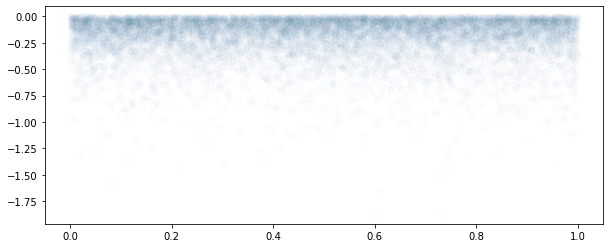

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

x = [p.pos for p in p_space]
y = [p.wait for p in p_space]
min_y = min(y)
y = [min_y-i for i in y]
# kde = stats.gaussian_kde(x)

# xticks = np.linspace(0, 1.0, 100)

fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(x, y, marker='o', alpha=0.01)
# ax.plot(xticks, kde(xticks))

In [10]:
current_time = 0.
t = 0
while len(p_space) > 0:
# while t < int(1e6):
    if t % 10000 == 0:
        print(t, len(p_space), len(d_space), current_time, sep='\t')
        # print(p_space, d_space, sep='\n')

    # Get next division event
    current_event = event_queue[0]
    # Check if division or loss
    if isinstance(current_event, LossEvent):
        # Remove D-cell and continue
        d_space.remove(Dcell(current_event.pos, current_event.wait, current_event.lineage))
        event_queue.remove(current_event)
        continue
    elif isinstance(current_event, DivisionEvent):
        # Proceed with division
        # P+P or P+D or D+D
        event_id, d1, d2 = division_result(current_event, pp_prob, pd_prob, dd_prob)

        # Remove current P-cell 
        p_space.remove(Pcell(current_event.pos, current_event.wait, current_event.lineage))
        event_queue.remove(current_event)

        if event_id == 0:
            # Insert d1 and d2 into P-space
            p_space.insert(d1)
            p_space.insert(d2)
            # Queue d1 and d2 divisions
            event_queue.insert(DivisionEvent(d1.pos, d1.wait, d1.lineage))
            event_queue.insert(DivisionEvent(d2.pos, d2.wait, d2.lineage))
        elif event_id == 1:
            # Insert d1 into P-space
            p_space.insert(d1)
            # Insert d2 into D-space
            d_space.insert(d2)
            # Queue d1 division 
            event_queue.insert(DivisionEvent(d1.pos, d1.wait, d1.lineage))
            # Queue d2 loss
            event_queue.insert(LossEvent(d2.pos, d2.wait, d2.lineage))
        elif event_id == 2:
            # Remove current P-cell and insert d1 and d2 into D-space
            d_space.insert(d1)
            d_space.insert(d2)
            # Queue d1 and d2 loss
            event_queue.insert(LossEvent(d1.pos, d1.wait, d1.lineage))
            event_queue.insert(LossEvent(d2.pos, d2.wait, d2.lineage))

    t += 1
    current_time = current_event.wait

print(t, len(p_space), len(d_space), current_time, sep='\t') 
# print(p_space, d_space, sep='\n')

0	10000	0	0.0
10000	10003	9026	0.20272047645499858
20000	9980	16513	0.3974082218629037
20000	9980	16512	0.3974082218629037
20000	9980	16511	0.3974082218629037
30000	9960	22612	0.5997328361798939
40000	10004	27408	0.7996007694078691
50000	10018	31481	1.000869907434541
60000	9994	35027	1.1978006313723932
70000	9942	37688	1.4006079957037525
80000	9900	39887	1.6047141364176514
90000	9927	41545	1.811195294190281
90000	9927	41544	1.811195294190281
100000	9942	43146	2.0089516664730223
110000	9998	44430	2.209196333644109
110000	9998	44429	2.209196333644109
120000	10026	45337	2.4068338690252418
120000	10026	45336	2.4068338690252418
130000	10003	46377	2.6046998898836233
130000	10003	46376	2.6046998898836233
130000	10003	46375	2.6046998898836233
130000	10003	46374	2.6046998898836233
140000	10032	47147	2.8036321688746026
140000	10032	47146	2.8036321688746026
140000	10032	47145	2.8036321688746026
140000	10032	47144	2.8036321688746026
140000	10032	47143	2.8036321688746026


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

x = [p.pos for p in p_space]
y = [p.wait for p in p_space]
min_y = min(y)
y = [min_y-i for i in y]
# kde = stats.gaussian_kde(x)

# xticks = np.linspace(0, 1.0, 100)

fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(x, y, marker='o', alpha=0.01)
# ax.plot(xticks, kde(xticks))